# Clustering Crypto

In [290]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pathlib import Path

### Fetching Cryptocurrency Data

In [291]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [292]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.

r = requests.get(url)
data = r.json()

In [293]:
# Alternatively, use the provided csv file:
# file_path = Path("Resources/crypto_data.csv")

# Create a DataFrame
file_path = Path("crypto_data.csv")
df_crypto = pd.read_csv(file_path)
df_crypto.head()

,value,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [294]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
df_crypto.drop(df_crypto.columns[df_crypto.columns.str.contains('value',case = False)],axis = 1, inplace = True)
#df_crypto = df_crypto.drop(df_crypto.columns[["Unnamed:0"]], axis=1)  # df.columns is zero-based pd.Index
#df_crypto.drop(['Unnamed:0'], axis=1, inplace=True)
#df_crypto = df_crypto.drop(columns=['Unnamed:0'])
#columns = [' ']
#df_crypto.drop(columns, inplace=True, axis=1)

#df_crypto = df_crypto.drop('value', axis=1)

In [295]:
df_crypto.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [296]:
# Keep only cryptocurrencies that are trading
df_crypto = df_crypto.loc[df_crypto['IsTrading'] == True]

In [297]:
# Keep only cryptocurrencies with a working algorithm
df_crypto = df_crypto.loc[df_crypto['Algorithm'] != 'N/A']

In [298]:
# Remove the "IsTrading" column
df_crypto = df_crypto.drop (columns = 'IsTrading')

In [299]:
# Remove rows with at least 1 null value
df_crypto.isnull().sum()

CoinName             0
Algorithm            0
ProofType            0
TotalCoinsMined    459
TotalCoinSupply      0
dtype: int64

In [300]:
# Remove rows with cryptocurrencies having no coins mined
df_crypto = df_crypto.loc[df_crypto['TotalCoinsMined'] != 0]

In [301]:
df_crypto.dropna(inplace=True)

In [302]:
# Drop rows where there are 'N/A' text values
df_crypto = df_crypto[df_crypto!='N/A']

In [303]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coinname_df = pd.DataFrame(
    data = df_crypto, columns = ['CoinName'])
print (coinname_df)

         CoinName
0         42 Coin
2         404Coin
5       EliteCoin
7         Bitcoin
8        Ethereum
...           ...
1238       ZEPHYR
1242      Gapcoin
1245       Beldex
1246      Horizen
1247  BitcoinPlus

[533 rows x 1 columns]


In [304]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
df_crypto = df_crypto.drop(columns = 'CoinName')
df_crypto.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,Scrypt,PoW/PoS,4.199995e+01,42
2,Scrypt,PoW/PoS,1.055185e+09,532000000
5,X13,PoW/PoS,2.927942e+10,314159265359
7,SHA-256,PoW,1.792718e+07,21000000
8,Ethash,PoW,1.076842e+08,0


In [305]:
df_crypto.shape

(533, 4)

In [306]:
# Create dummy variables for text features
crypto_dummies= pd.get_dummies(df_crypto, columns=['Algorithm', 'ProofType'])
crypto_dummies.head()

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
0,4.199995e+01,42,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1.055185e+09,532000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,2.927942e+10,314159265359,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,1.792718e+07,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1.076842e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [307]:
pca_df.shape

(533, 4)

In [308]:
# Standardize data

#scaler = StandardScaler().fit(X)
#X = scaler.transform(X)

#def (crypto_scaled) = crypto_scaled[~np.isnan(crypto_scaled).any(axis=1)]
#np.isnan(crypto_scaled).sum()



#Crete Standard Scaler Instance 
scaler = StandardScaler()

#Standardize data 
X_scaled = scaler.fit_transform(crypto_dummies)


In [309]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)

crypto_pca = pca.fit_transform(X_scaled)

In [310]:
# Create a DataFrame with the principal components data
pca_df = pd.DataFrame(
    data=crypto_pca, columns=["PC 1", "PC 2", "PC 3"]
)
pca_df.head()

,PC 1,PC 2,PC 3
0,-0.330289,0.902858,-0.613248
1,-0.313633,0.903450,-0.613653
2,2.301228,1.775212,-0.794766
3,-0.146623,-1.278454,0.202430
4,-0.154246,-1.990905,0.474734


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [311]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(crypto_pca)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")



C:\Users\johnm\anaconda3\envs\alpacaenv\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



:Curve   [k]   (inertia)

Running K-Means with `k=<your best value for k here>`

In [312]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=0)
# Fit the model
model.fit(pca_df)
# Predict clusters
predictions = model.predict(pca_df)

# Create a new DataFrame including predicted clusters and cryptocurrencies features

pca_df['class'] = model.labels_

df_merged = pd.concat([df_crypto.reset_index(drop=True),coinname_df.reset_index(drop=True)], axis=1)
df_merged = df_merged.join(pca_df)

df_merged.tail(20)
# Fit the model

# Predict clusters

# Create a new DataFrame including predicted clusters and cryptocurrencies features


,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,CoinName,PC 1,PC 2,PC 3,class
513,Scrypt,PoS,1.000024e+10,10008835635,HiCoin,-0.091732,0.717175,-0.243732,0
514,Scrypt,PoW/PoS,2.520056e+08,300000000,WhiteCoin,-0.325087,0.902964,-0.613354,0
515,NeoScrypt,PoW/PoS,1.120385e+06,60168145,FriendshipCoin,-0.353594,0.601100,-0.406845,0
516,SHA3-256,DPoC,-5.917978e+09,5000000000,Fiii,-0.587077,5.568662,11.368540,3
517,Multiple,PoW,3.332922e+06,2800000,JoinCoin,-0.128714,-1.761817,0.474153,1
518,X13,PoW/PoS,1.407778e+05,120000,Triangles Coin,-0.280491,1.819868,-0.768136,0
519,Equihash+Scrypt,PoW,1.000000e+08,2100000000,Vollar,-0.124518,-2.167368,0.483302,1
520,DPoS,DPoS,1.020545e+09,0,EOS,3.783357,0.801654,0.010785,0
521,Ethash,PoW,2.448794e+07,24487944,Reality Clash,-0.155089,-1.990965,0.474763,1
522,DPoS,DPoS,1.122382e+09,0,Oxycoin,3.784601,0.801721,0.010749,0


### Visualizing Results

#### 3D-Scatter with Clusters

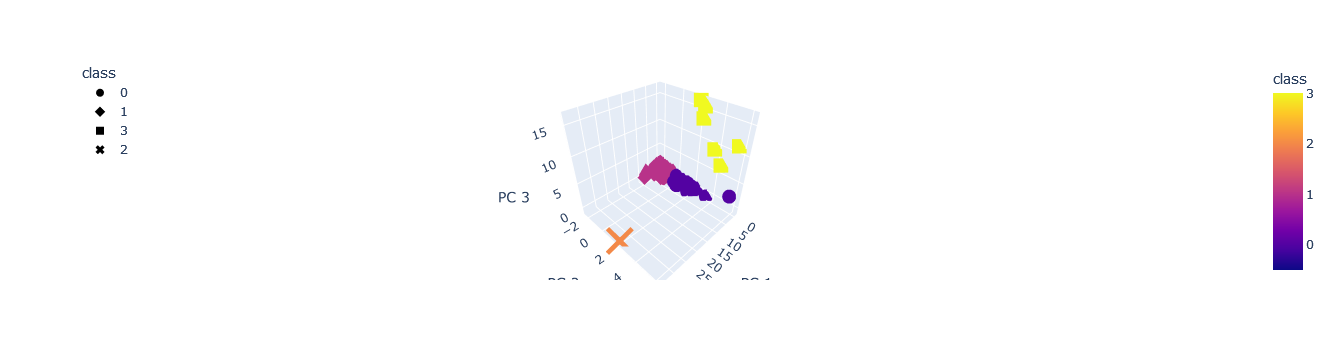

In [313]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    df_merged,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    hover_name='CoinName',
    hover_data= ['Algorithm'],
    color="class",
    symbol="class",
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

#### Table of Tradable Cryptocurrencies

In [314]:
# Table with tradable cryptos
columns = ['CoinName', 'Algorithm', 'ProofType', 'TotalCoinSupply', 'TotalCoinsMined', 'class']

In [315]:
# Print the total number of tradable cryptocurrencies
df_merged.hvplot.table(columns)

:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,class]

#### Scatter Plot with Tradable Cryptocurrencies

In [316]:
# Scale data to create the scatter plot
df_merged['TotalCoinsMined'] = df_merged['TotalCoinsMined'].astype(float) / 1000000
df_merged['TotalCoinSupply'] = df_merged['TotalCoinSupply'].astype(float) / 1000000

In [317]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
df_merged.hvplot(
    kind="scatter", 
    x="TotalCoinsMined", 
    y="TotalCoinSupply", 
    c='class', 
    colormap="viridis", 
    hover_cols=['CoinName']
)

:Scatter   [TotalCoinsMined]   (TotalCoinSupply,class,CoinName)